In [23]:
import psycopg2
import matplotlib.pyplot as plt

In [24]:
def get_conn():
    conn = psycopg2.connect (
        host     = "cc3201.dcc.uchile.cl",
        database = "cc3201",
        user     = "cc3201",
        password = "j'<3_cc3201",
        port     = "5440"
    )
    return conn

In [25]:
def size_table(tamanno):
    conn = get_conn()
    cur  = conn.cursor() 
    consulta = f"select count(*) from opt.pelicula{tamanno};"
    cur.execute(consulta)
    size = cur.fetchone()
    conn.close()
    return float(size[0])


In [26]:
def time_cons(tamanno: int, optimizacion: str, anidada: bool):
    conn = get_conn()
    cur = conn.cursor()

    if anidada:
        consulta = f"""
            explain analyze
            select distinct pelicula.nombre, pelicula.anho
            from {optimizacion}.pelicula{tamanno}  as pelicula,
                 {optimizacion}.personaje{tamanno} as personaje
            where pelicula.nombre = personaje.p_nombre
            and   pelicula.anho   = personaje.p_anho
            and   personaje.a_nombre in (
                select  personaje.a_nombre 
                from  {optimizacion}.pelicula{tamanno}  as pelicula,
                      {optimizacion}.personaje{tamanno} as personaje
                where personaje.p_nombre = pelicula.nombre
                and   pelicula.nombre = 'Batman v Superman: Dawn of Justice'
            );"""
    else:
        consulta = f"""
            explain analyze
            select distinct pelicula1.nombre, pelicula1.anho
            from {optimizacion}.pelicula{tamanno} as pelicula1,
                 {optimizacion}.personaje{tamanno} as personaje1,
                 {optimizacion}.pelicula{tamanno} as pelicula2,
                 {optimizacion}.personaje{tamanno} as personaje2
            where pelicula1.nombre = personaje1.p_nombre
            and   pelicula1.anho   = personaje1.p_anho
            and   pelicula2.nombre = personaje2.p_nombre
            and   pelicula2.anho   = personaje2.p_anho
            and   pelicula2.nombre = 'Batman v Superman: Dawn of Justice'
            and   personaje2.a_nombre = personaje1.a_nombre;
            """

    cur.execute(consulta)
    r = cur.fetchone()

    while (r):
        r = r[0]
        if("Planning Time" in r):
            p_time = r
        if("Execution Time" in r):
            e_time = r
        r = cur.fetchone()

    conn.close()
    return  p_time, e_time



In [27]:
ns = [100, 1000, 10000]
size_tables = [size_table(x)/(10**4) for x in ns]

AttributeError: module 'psycopg2' has no attribute 'connect'

In [ ]:
def get_result(optimizacion, anidado):
    y = []
    for n in ns:
        p_time, e_time = time_cons(n, optimizacion, anidado)
        print("\t",str(n)+":"+" "*(6 - len(str(n))), p_time, e_time)

        p_time = p_time.replace("Planning Time: ", "").replace(" ms", "")
        e_time = e_time.replace("Execution Time: ", "").replace(" ms", "")

        y.append(float(p_time) + float(e_time))
    return y

In [ ]:
print("Consulta anidada: \n")

print("  Consulta no optimizada: ")
opt_anidada = get_result("opt", True)
plt.plot(size_tables, opt_anidada, marker='x', color='r', linestyle='-', label="opt")

print("  Consulta optimizada: ")
opti_anidada = get_result("opti", True)
plt.plot(size_tables, opti_anidada, marker='o', color='b', linestyle='-', label="opti")

plt.ylabel("Tiempo (ms)")
plt.xlabel("Tamaño (tuplas)"+" "*20+r"$\cdot 10^{4}$")
plt.title("Consulta con anidación")
plt.legend()
plt.show()

Consulta anidada: 

  Consulta no optimizada: 


NameError: name 'psycopg2' is not defined

Consulta no anidada: 

  consulta no optimizada:
	 100:    Planning Time: 3.790 ms Execution Time: 142.935 ms
	 1000:   Planning Time: 4.880 ms Execution Time: 72.676 ms
	 10000:  Planning Time: 3.109 ms Execution Time: 37.018 ms
  consulta optimizada:
	 100:    Planning Time: 4.890 ms Execution Time: 25.631 ms
	 1000:   Planning Time: 3.953 ms Execution Time: 12.960 ms
	 10000:  Planning Time: 5.985 ms Execution Time: 10.632 ms


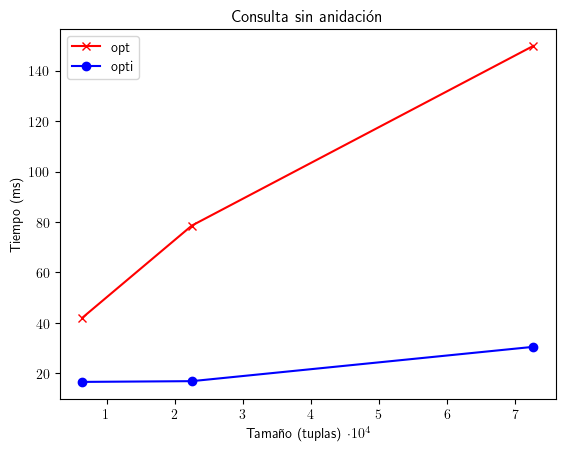

In [ ]:
print("Consulta no anidada: \n")

print("  consulta no optimizada:")
opt_no_anidada = get_result("opt", False)
plt.plot(size_tables, opt_anidada, marker='x',color='r', linestyle='-', label="opt")

print("  consulta optimizada:")
opti_no_anidada = get_result("opti", False)
plt.plot(size_tables, opti_no_anidada, marker='o', color='b', linestyle='-', label="opti")

plt.ylabel("Tiempo (ms)")
plt.xlabel("Tamaño (tuplas)"+" "*10+r"$\cdot 10^4$")
plt.legend()
plt.title("Consulta sin anidación")
plt.show()